In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Matplotlib is building the font cache; this may take a moment.


**#SUBMITTED BY CS22MTECH02002 SHIKHAR JAIN**

In [5]:
epsilon=0.000001

In [6]:
# Load MNIST dataset
train_data = MNIST(root='data', train=True, transform=ToTensor(), download=True)
test_data = MNIST(root='data', train=False, transform=ToTensor(), download=True)

# Create data loaders
batch_size=100
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)



100%|██████████| 9912422/9912422 [00:00<00:00, 37810744.20it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 32748227.58it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 8442765.55it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7268419.98it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [19]:
small_train=[]
small_test=[]
for x in range(30000):
  small_train.append(train_data[x])
for x in range(5000):
  small_test.append(test_data[x])  


#***Q1) Autoencoders: In this task, consider the MNIST dataset for training autoencoder models (with a suitable regularization) with hidden (latent) dimension of 32, and 64.***

***(a) Report the train and test reconstruction errors for the three models (display about 10 reconstructions from the train and test data each).***

***(b) Perform the reconstruction on the line joining two training data samples in the hidden space.Consider at least 5 pairs of samples. ***

In [12]:
# Define autoencoder model with 32 and 64 hidden dimensions
class Naive_Autoencoder(nn.Module):
    def __init__(self, hidden_dim):
        super(Naive_Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, hidden_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, 28*28),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        #print("((((")
        #print(x)
        x = x.view(x.size(0), -1) # flatten the incoming image 
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat   

In [46]:
def normal_train(model, train_data, epoch, optimizer, criterion):
  model.train()    
  train_loss_per_epoch=[]
  for e in range(epoch):
    train_loss = 0
    for data in train_data:
        optimizer.zero_grad()
        recon = model(data[0])
        #print(data[0].view(data[0].size(0),-1).shape)
        loss = criterion(recon, data[0].view(data[0].size(0),-1))
        #reg_loss = 0
        # for param in model.parameters():
        #     reg_loss += torch.sum(torch.square(param))
        # loss += reg_lambda * reg_loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss_per_epoch.append(train_loss / len(train_data))
    print(f"***** Without any regularaization [{e+1}/{epoch}], Train Loss: {train_loss/len(train_data):.4f} *******")
  return train_loss_per_epoch

def l2_reg_train(model, train_data, epoch, optimizer, criterion, reg_lambda):
  model.train()    
  train_loss_per_epoch=[]
  for e in range(epoch):
    train_loss = 0
    for data in train_data:
        optimizer.zero_grad()
        recon = model(data[0])
        #print(data[0].view(data[0].size(0),-1).shape)
        loss = criterion(recon, data[0].view(data[0].size(0),-1))
        reg_loss = 0
        for param in model.parameters():
            reg_loss += torch.sum(torch.square(param))
        loss += reg_lambda * reg_loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss_per_epoch.append(train_loss / len(train_data))
    print(f"***** L2 Regularaized Epoch [{e+1}/{epoch}], Train Loss: {train_loss/len(train_data):.4f} *******")
  return train_loss_per_epoch
    

# Define training function
def denoised_train(model, train_data, epoch, optimizer, criterion, noise_factor):
  model.train()    
  train_loss_per_epoch=[]
  for e in range(epoch):
    train_loss = 0
    for data in train_data:
        #print(data[0].shape)
        optimizer.zero_grad()
        x_noisy = data[0] + noise_factor * torch.randn(data[0].size())
        x_noisy = torch.clamp(x_noisy, 0., 1.)
        recon = model(x_noisy)
        loss = criterion(recon, data[0].view(data[0].size(0),-1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss_per_epoch.append(train_loss / len(train_data))
    print(f"***** DENOISED with Standard Gaussian Epoch [{e+1}/{epoch}], Train Loss: {train_loss/len(train_data):.4f} *******")    
  return train_loss_per_epoch

def sparse_train(model, train_data, epoch, optimizer, criterion, sparse_weight,sparse_target,sparse_priority):
  model.train()    
  train_loss_per_epoch=[]
  for e in range(epoch):
    train_loss = 0
    loss=0
    mean_activation=0
    optimizer.zero_grad()
    for data in train_data:
        #print(data[0].shape)                
        recon = model(data[0])
        loss+= criterion(recon, data[0].view(data[0].size(0),-1))
        #print("####",loss)
        #sp_loss=sparse_loss(model,data[0].view(data[0].size(0),-1),sparse_weight,sparse_target)
        mean_activation += torch.add(torch.mean(torch.abs(model.encoder(data[0].view(data[0].size(0),-1)))),epsilon)
        #print("@@@",mean_activation)

    mean_activation/=len(train_data)
    sp_loss=sparse_weight * torch.sum(sparse_target * torch.log(sparse_target / (mean_activation)) +
                                              (1 - sparse_target) * torch.log(abs((1 - sparse_target) / (1 - mean_activation))))
        #print("!!!!",sp_loss)
        #print("****", torch.log((1 - sparse_target) / (1 - mean_activation)))
        #print("^^^^",torch.log(sparse_target / (mean_activation)))
    loss=loss+sparse_priority*sp_loss
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    train_loss_per_epoch.append(train_loss / len(train_data))
    print(f"***** Sparse with target {sparse_target} Epoch [{e+1}/{epoch}], Train Loss: {train_loss/len(train_data):.4f} *******")    
  return train_loss_per_epoch






*****32 dim latent layer model intialization*****

In [14]:
model_32_l2=Naive_Autoencoder(32)
model_32_denoised=Naive_Autoencoder(32)
model_32_sparse=Naive_Autoencoder(32)
lr=0.01
epoch=10
optimizer_l2=optim.Adam(model_32_l2.parameters(), lr=lr)
optimizer_denoised=optim.Adam(model_32_denoised.parameters(), lr=lr)
optimizer_sparse=optim.Adam(model_32_sparse.parameters(), lr=lr)
criterion=nn.MSELoss()
#contarctive_train_loss_per_epoch=contractive_train(model_16,small_train,epoch,optimizer)

In [49]:
model_32=Naive_Autoencoder(32)
optimizer=optim.Adam(model_32.parameters(), lr=lr)

In [15]:
l2_train_loss_per_epoch=l2_reg_train(model_32_l2,train_data,epoch,optimizer_l2,criterion,0.1)

***** L2 Regularaized Epoch [1/10], Train Loss: 0.2345 *******
***** L2 Regularaized Epoch [2/10], Train Loss: 0.2319 *******
***** L2 Regularaized Epoch [3/10], Train Loss: 0.2319 *******
***** L2 Regularaized Epoch [4/10], Train Loss: 0.2319 *******
***** L2 Regularaized Epoch [5/10], Train Loss: 0.2319 *******
***** L2 Regularaized Epoch [6/10], Train Loss: 0.2319 *******
***** L2 Regularaized Epoch [7/10], Train Loss: 0.2319 *******
***** L2 Regularaized Epoch [8/10], Train Loss: 0.2319 *******
***** L2 Regularaized Epoch [9/10], Train Loss: 0.2319 *******
***** L2 Regularaized Epoch [10/10], Train Loss: 0.2319 *******


In [16]:
denoised_train_loss_per_epoch=denoised_train(model_32_denoised,train_data,epoch,optimizer_denoised,criterion,0.5)

***** DENOISED with Standard Gaussian Epoch [1/10], Train Loss: 0.0606 *******
***** DENOISED with Standard Gaussian Epoch [2/10], Train Loss: 0.0665 *******
***** DENOISED with Standard Gaussian Epoch [3/10], Train Loss: 0.0670 *******
***** DENOISED with Standard Gaussian Epoch [4/10], Train Loss: 0.0670 *******
***** DENOISED with Standard Gaussian Epoch [5/10], Train Loss: 0.0670 *******
***** DENOISED with Standard Gaussian Epoch [6/10], Train Loss: 0.0670 *******
***** DENOISED with Standard Gaussian Epoch [7/10], Train Loss: 0.0670 *******
***** DENOISED with Standard Gaussian Epoch [8/10], Train Loss: 0.0670 *******
***** DENOISED with Standard Gaussian Epoch [9/10], Train Loss: 0.0670 *******
***** DENOISED with Standard Gaussian Epoch [10/10], Train Loss: 0.0670 *******


In [17]:
sparse_train_loss_per_epoch=sparse_train(model_32_sparse,train_data,epoch,optimizer_sparse,criterion,0.8,0.05,1)

***** Sparse with target 0.05 Epoch [1/10], Train Loss: 0.2316 *******
***** Sparse with target 0.05 Epoch [2/10], Train Loss: 0.2091 *******
***** Sparse with target 0.05 Epoch [3/10], Train Loss: 0.1791 *******
***** Sparse with target 0.05 Epoch [4/10], Train Loss: 0.1473 *******
***** Sparse with target 0.05 Epoch [5/10], Train Loss: 0.1201 *******
***** Sparse with target 0.05 Epoch [6/10], Train Loss: 0.1001 *******
***** Sparse with target 0.05 Epoch [7/10], Train Loss: 0.0875 *******
***** Sparse with target 0.05 Epoch [8/10], Train Loss: 0.0810 *******
***** Sparse with target 0.05 Epoch [9/10], Train Loss: 0.0777 *******
***** Sparse with target 0.05 Epoch [10/10], Train Loss: 0.0756 *******


In [50]:
normal_train_loss_per_epoch=normal_train(model_32,train_data,epoch,optimizer,criterion)

***** Without any regularaization [1/10], Train Loss: 0.0517 *******
***** Without any regularaization [2/10], Train Loss: 0.0582 *******
***** Without any regularaization [3/10], Train Loss: 0.0580 *******
***** Without any regularaization [4/10], Train Loss: 0.0576 *******
***** Without any regularaization [5/10], Train Loss: 0.0570 *******
***** Without any regularaization [6/10], Train Loss: 0.0567 *******
***** Without any regularaization [7/10], Train Loss: 0.0561 *******
***** Without any regularaization [8/10], Train Loss: 0.0557 *******
***** Without any regularaization [9/10], Train Loss: 0.0556 *******
***** Without any regularaization [10/10], Train Loss: 0.0555 *******


*****64 dim latent layer model intialization*****

In [20]:
model_64_l2=Naive_Autoencoder(64)
model_64_denoised=Naive_Autoencoder(64)
model_64_sparse=Naive_Autoencoder(64)
lr=0.01
epoch=10
optimizer_l2_64=optim.Adam(model_64_l2.parameters(), lr=lr)
optimizer_denoised_64=optim.Adam(model_64_denoised.parameters(), lr=lr)
optimizer_sparse_64=optim.Adam(model_64_sparse.parameters(), lr=lr)
criterion=nn.MSELoss()


In [53]:
model_64=Naive_Autoencoder(64)
optimizer_64=optim.Adam(model_64.parameters(), lr=lr)

In [21]:
l2_train_loss_per_epoch_64=l2_reg_train(model_64_l2,train_data,epoch,optimizer_l2_64,criterion,0.6)

***** L2 Regularaized Epoch [1/10], Train Loss: 0.2488 *******
***** L2 Regularaized Epoch [2/10], Train Loss: 0.2359 *******
***** L2 Regularaized Epoch [3/10], Train Loss: 0.2359 *******
***** L2 Regularaized Epoch [4/10], Train Loss: 0.2359 *******
***** L2 Regularaized Epoch [5/10], Train Loss: 0.2359 *******
***** L2 Regularaized Epoch [6/10], Train Loss: 0.2359 *******
***** L2 Regularaized Epoch [7/10], Train Loss: 0.2359 *******
***** L2 Regularaized Epoch [8/10], Train Loss: 0.2359 *******
***** L2 Regularaized Epoch [9/10], Train Loss: 0.2359 *******
***** L2 Regularaized Epoch [10/10], Train Loss: 0.2359 *******


In [22]:
denoised_train_loss_per_epoch_64=denoised_train(model_64_denoised,train_data,epoch,optimizer_denoised_64,criterion,0.5)

***** DENOISED with Standard Gaussian Epoch [1/10], Train Loss: 0.0610 *******
***** DENOISED with Standard Gaussian Epoch [2/10], Train Loss: 0.0658 *******
***** DENOISED with Standard Gaussian Epoch [3/10], Train Loss: 0.0670 *******
***** DENOISED with Standard Gaussian Epoch [4/10], Train Loss: 0.0670 *******
***** DENOISED with Standard Gaussian Epoch [5/10], Train Loss: 0.0670 *******
***** DENOISED with Standard Gaussian Epoch [6/10], Train Loss: 0.0670 *******
***** DENOISED with Standard Gaussian Epoch [7/10], Train Loss: 0.0670 *******
***** DENOISED with Standard Gaussian Epoch [8/10], Train Loss: 0.0670 *******
***** DENOISED with Standard Gaussian Epoch [9/10], Train Loss: 0.0670 *******
***** DENOISED with Standard Gaussian Epoch [10/10], Train Loss: 0.0670 *******


In [23]:
sparse_train_loss_per_epoch_64=sparse_train(model_64_sparse,train_data,epoch,optimizer_sparse_64,criterion,0.8,0.05,1)

***** Sparse with target 0.05 Epoch [1/10], Train Loss: 0.2314 *******
***** Sparse with target 0.05 Epoch [2/10], Train Loss: 0.1848 *******
***** Sparse with target 0.05 Epoch [3/10], Train Loss: 0.1292 *******
***** Sparse with target 0.05 Epoch [4/10], Train Loss: 0.0939 *******
***** Sparse with target 0.05 Epoch [5/10], Train Loss: 0.0802 *******
***** Sparse with target 0.05 Epoch [6/10], Train Loss: 0.0767 *******
***** Sparse with target 0.05 Epoch [7/10], Train Loss: 0.0760 *******
***** Sparse with target 0.05 Epoch [8/10], Train Loss: 0.0748 *******
***** Sparse with target 0.05 Epoch [9/10], Train Loss: 0.0744 *******
***** Sparse with target 0.05 Epoch [10/10], Train Loss: 0.0739 *******


In [55]:
normal_train_loss_per_epoch_64=normal_train(model_64,train_data,epoch,optimizer_64,criterion)

***** Without any regularaization [1/10], Train Loss: 0.0517 *******
***** Without any regularaization [2/10], Train Loss: 0.0527 *******
***** Without any regularaization [3/10], Train Loss: 0.0509 *******
***** Without any regularaization [4/10], Train Loss: 0.0500 *******
***** Without any regularaization [5/10], Train Loss: 0.0489 *******
***** Without any regularaization [6/10], Train Loss: 0.0487 *******
***** Without any regularaization [7/10], Train Loss: 0.0484 *******
***** Without any regularaization [8/10], Train Loss: 0.0482 *******
***** Without any regularaization [9/10], Train Loss: 0.0478 *******
***** Without any regularaization [10/10], Train Loss: 0.0476 *******


*****functions for calculating test data loss *****

In [56]:
#get test reconstruction error
def test_reconst(model,test_data):
  loss=0
  with torch.no_grad() :
    for data in test_data:
      test_recon=model(data[0].view(data[0].size(0),-1))
      loss += criterion(test_recon, data[0].view(data[0].size(0),-1))
    return loss/len(test_data)  


def l2_test_reconst(model,test_data):
  loss=0
  with torch.no_grad() :
    for data in test_data:
      test_recon=model(data[0].view(data[0].size(0),-1))
      loss += criterion(test_recon, data[0].view(data[0].size(0),-1))
    return loss/len(test_data)  



def denoised_test_reconst(model,test_data):
  loss=0
  with torch.no_grad() :
    for data in test_data:
      test_recon=model(data[0].view(data[0].size(0),-1))
      loss+=criterion(test_recon, data[0].view(data[0].size(0),-1))
    return loss/len(test_data) 


def sparse_test_reconst(model,test_data,sparse_weight,sparse_target,sparse_priority):
  loss=0
  mean_activation=0
  with torch.no_grad() :
    for data in test_data:
      test_recon=model(data[0].view(data[0].size(0),-1))
      loss+=criterion(test_recon, data[0].view(data[0].size(0),-1))
      mean_activation += torch.add(torch.mean(torch.abs(model.encoder(data[0].view(data[0].size(0),-1)))),epsilon)
        #print("@@@",mean_activation)

    loss=loss/len(test_data)
    mean_activation/=len(test_data)
    sp_loss=sparse_weight* torch.sum(sparse_target * torch.log(sparse_target / (mean_activation)) +
                                              (1 - sparse_target) * torch.log(abs((1 - sparse_target) / (1 - mean_activation))))
        #print("!!!!",sp_loss)
        #print("****", torch.log((1 - sparse_target) / (1 - mean_activation)))
        #print("^^^^",torch.log(sparse_target / (mean_activation)))
    return loss+sparse_priority*sp_loss



In [57]:
l2_reconst_test_loss=l2_test_reconst(model_32_l2,test_data)
l2_reconst_test_loss_64=l2_test_reconst(model_64_l2,test_data)
denoised_reconst_test_loss=denoised_test_reconst(model_32_denoised,test_data)
denoised_reconst_test_loss_64=denoised_test_reconst(model_64_denoised,test_data)
sparse_reconst_test_loss=sparse_test_reconst(model_32_sparse,test_data,0.8,0.05,1)
sparse_reconst_test_loss_64=sparse_test_reconst(model_64_sparse,test_data,0.8,0.05,1)

In [58]:
reconst_test_loss=l2_test_reconst(model_32,test_data)
reconst_test_loss_64=l2_test_reconst(model_64,test_data)

*****setting a dataframe to save all 6 models performance *****

In [59]:
test_train_loss=pd.DataFrame(columns=['latent_dim','regularizer','final_train_loss','test_loss'])
test_train_loss['latent_dim']=[32,32,32,32,64,64,64,64]
test_train_loss['regularizer']=['No regularizaer','L2','denoised','sparse','No regularizaer','L2','denoised','sparse']
test_train_loss['final_train_loss']=[normal_train_loss_per_epoch[-1],l2_train_loss_per_epoch[-1],sparse_train_loss_per_epoch[-1],denoised_train_loss_per_epoch[-1],normal_train_loss_per_epoch_64[-1],l2_train_loss_per_epoch_64[-1],sparse_train_loss_per_epoch_64[-1],denoised_train_loss_per_epoch_64[-1]]
test_train_loss['test_loss']=[reconst_test_loss,l2_reconst_test_loss,sparse_reconst_test_loss,denoised_reconst_test_loss,reconst_test_loss_64,l2_reconst_test_loss_64,sparse_reconst_test_loss_64,denoised_reconst_test_loss_64]

In [60]:
from tabulate import tabulate
print(tabulate(test_train_loss,headers='keys', tablefmt='psql'))

+----+--------------+-----------------+--------------------+-------------+
|    |   latent_dim | regularizer     |   final_train_loss |   test_loss |
|----+--------------+-----------------+--------------------+-------------|
|  0 |           32 | No regularizaer |          0.0555214 |   0.0566787 |
|  1 |           32 | L2              |          0.231856  |   0.231201  |
|  2 |           32 | denoised        |          0.075625  |  -0.547782  |
|  3 |           32 | sparse          |          0.0670147 |   0.0882122 |
|  4 |           64 | No regularizaer |          0.0476055 |   0.0458668 |
|  5 |           64 | L2              |          0.235897  |   0.231399  |
|  6 |           64 | denoised        |          0.0739443 |  -0.6421    |
|  7 |           64 | sparse          |          0.0670147 |   0.0928696 |
+----+--------------+-----------------+--------------------+-------------+


*****generating reconstruction for train and test samples*****

In [61]:
#display train and test reconstruction error
train_set_radn_index=np.random.randint(0,len(train_data)-1,10)
test_set_radn_index=np.random.randint(0,len(test_data)-1,10)

In [62]:
def image_reconst(model,train_set_radn_index,test_set_radn_index):
  for i in range(len(train_set_radn_index)):
    fig,ax=plt.subplots(nrows=1,ncols=4,figsize=(10,5))
    plt.subplots_adjust(wspace=0.2)
    tr1=train_data[train_set_radn_index[i]][0]
    print(tr1[0].shape)
    ax[0].imshow(tr1.squeeze(0))
    ax[0].set_title("Actual Train Image")
    ax[1].imshow(model(tr1.view(tr1.size(0),-1)).detach().numpy().reshape(28,28))
    ax[1].set_title("Train Reconst")
    tt1=test_data[test_set_radn_index[i]][0]
    ax[2].imshow(tt1.squeeze(0))
    ax[2].set_title("Actual Test Image")
    ax[3].imshow(model(tt1.view(tt1.size(0),-1)).detach().numpy().reshape(28,28))
    ax[3].set_title("Test Reconst")

torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])


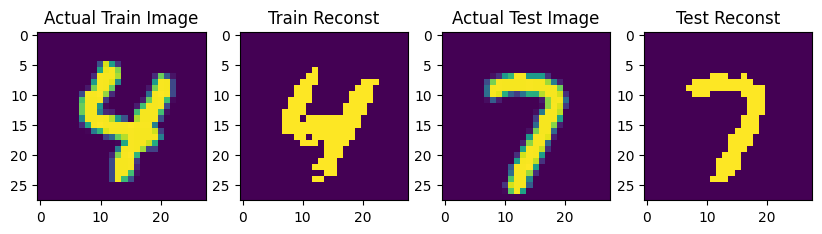

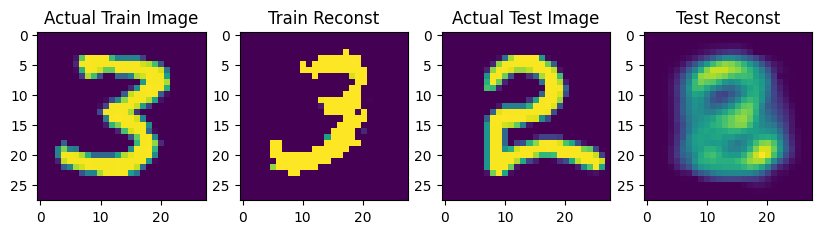

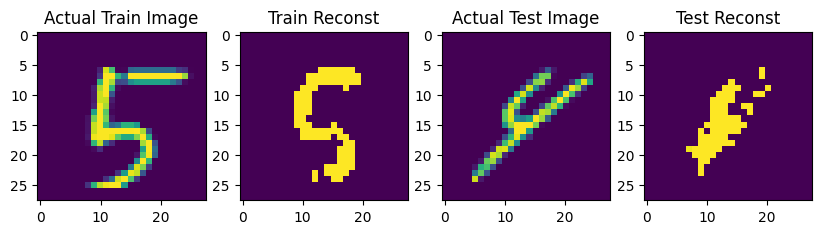

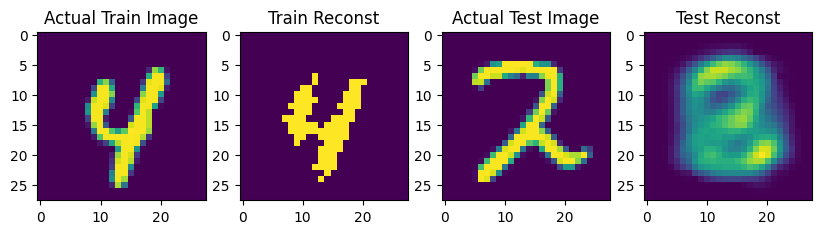

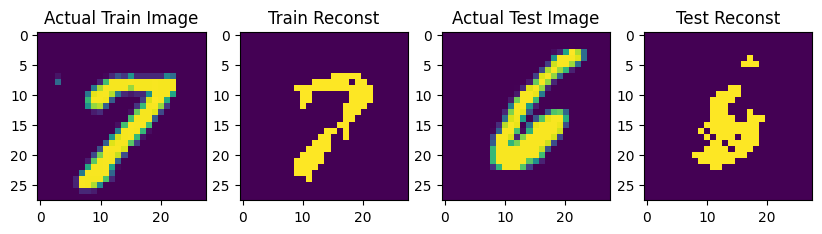

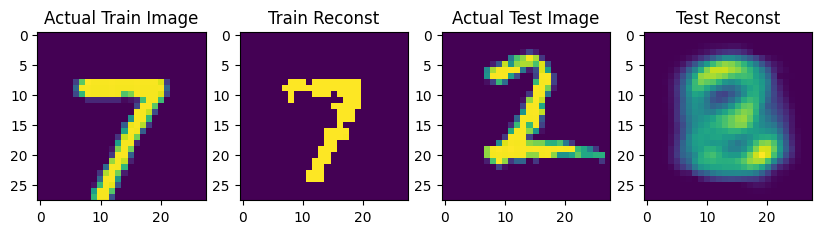

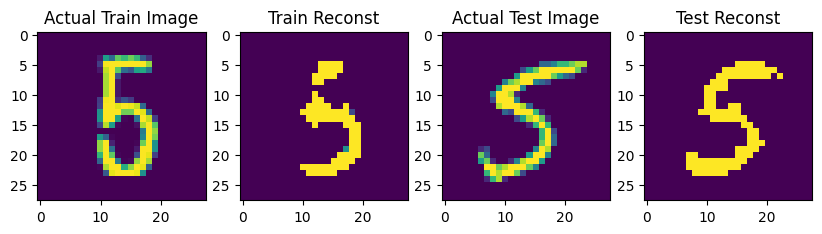

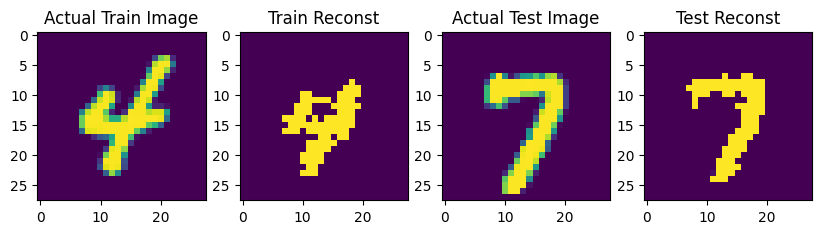

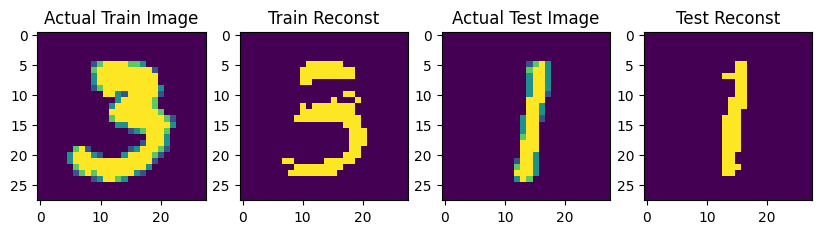

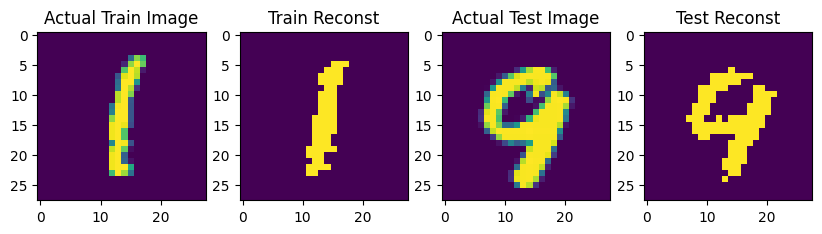

In [63]:
image_reconst(model_32,train_set_radn_index,test_set_radn_index)

torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])


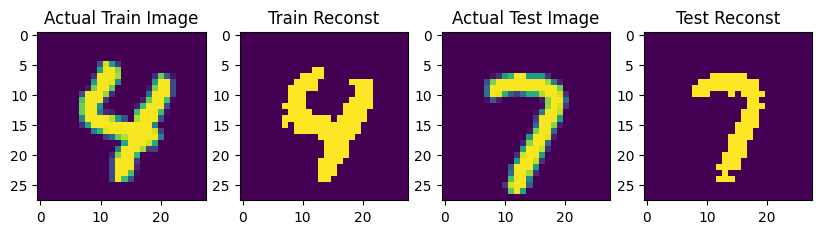

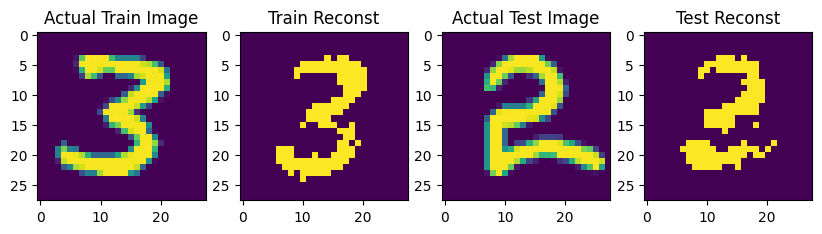

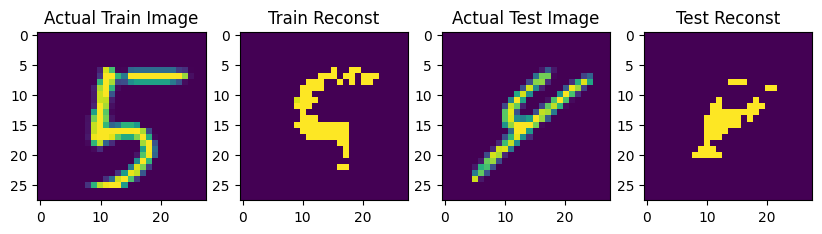

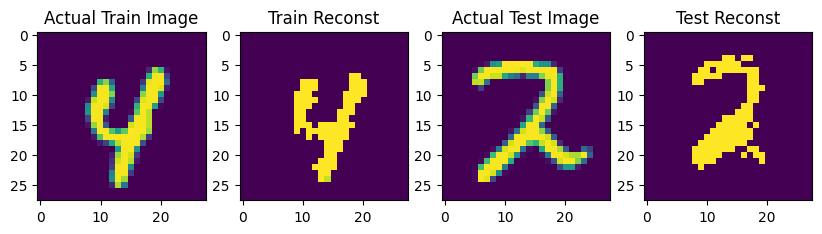

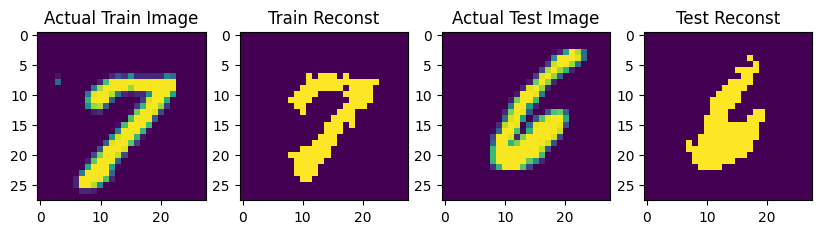

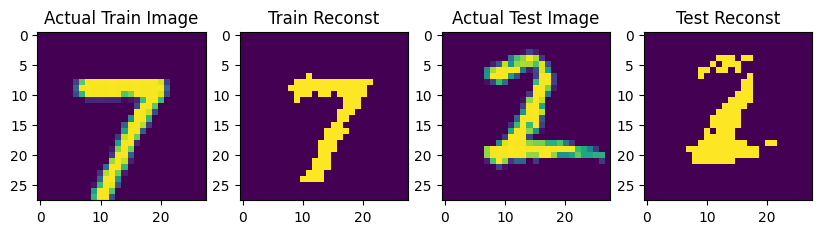

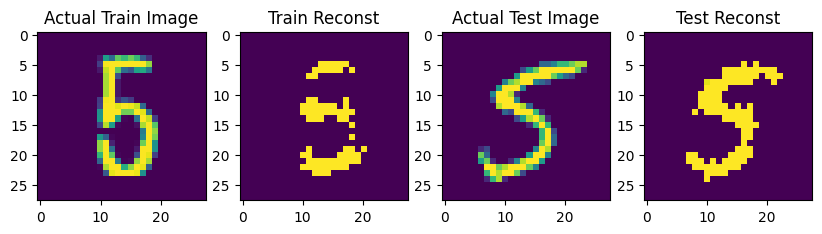

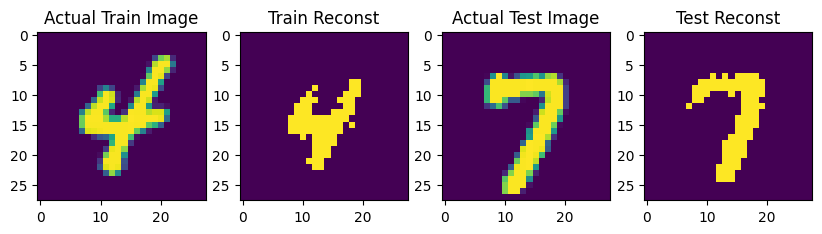

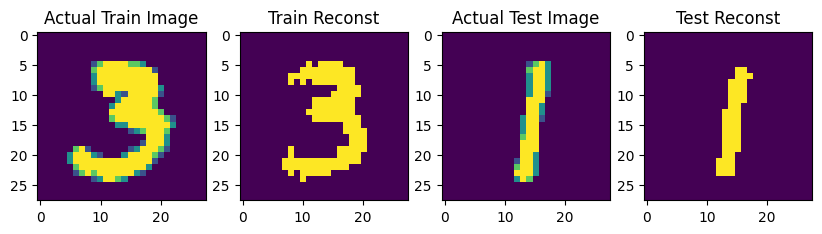

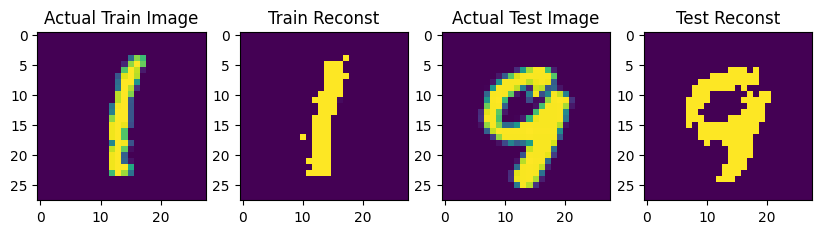

In [64]:
image_reconst(model_64,train_set_radn_index,test_set_radn_index)

In [36]:
#image_reconst(model_64_sparse,train_set_radn_index,test_set_radn_index)

***** EXERCISING INTERPOLATION *****

In [65]:
#get the latent representation of all teh train data
def get_latent_space(model,train_data):
  latent_represen=[]
  for data in train_data:
    latent_represen.append(model.encoder(data[0].view(data[0].size(0),-1)))
  return latent_represen   

In [66]:
#interpolation of a N pair of sample (interplolating latent representaion of train data samples )
def interpolate_and_plot(model,train_data):
  latent_rep=get_latent_space(model,train_data)
  
  with torch.no_grad():
    fig,ax=plt.subplots(nrows=5,ncols=15,figsize=(30,10))
    l=[]
    for i in range(5):      
      plt.subplots_adjust(wspace=0.2,hspace=0.3)
      latent_set_radn_index=np.random.randint(0,len(train_data)-1,2)
      l.append(latent_set_radn_index)        
      z1 = latent_rep[latent_set_radn_index[0]]
      z2 = latent_rep[latent_set_radn_index[1]]
      alphas = np.linspace(0, 1, num=15)
      recon_data = []
      for alpha in alphas:
        z = (1-alpha)*z1 + alpha*z2
        recon = model.decoder(z)
        recon_data.append(recon.reshape(28,28))
      for r in range(len(recon_data)):
        ax[i][r].imshow(recon_data[r])
      
    #plt.figure(figsize=(10,10))
    #plt.imshow(recon_data, cmap='gray')
    s=''
    for x in l:
      print(x)
      s=s+str(x)+" "
    fig.suptitle(f"interpolation of latent pairs {s}")
    #plt.show() 

[48158 35382]
[24574 35520]
[30202 48264]
[33737 22996]
[58804 33706]


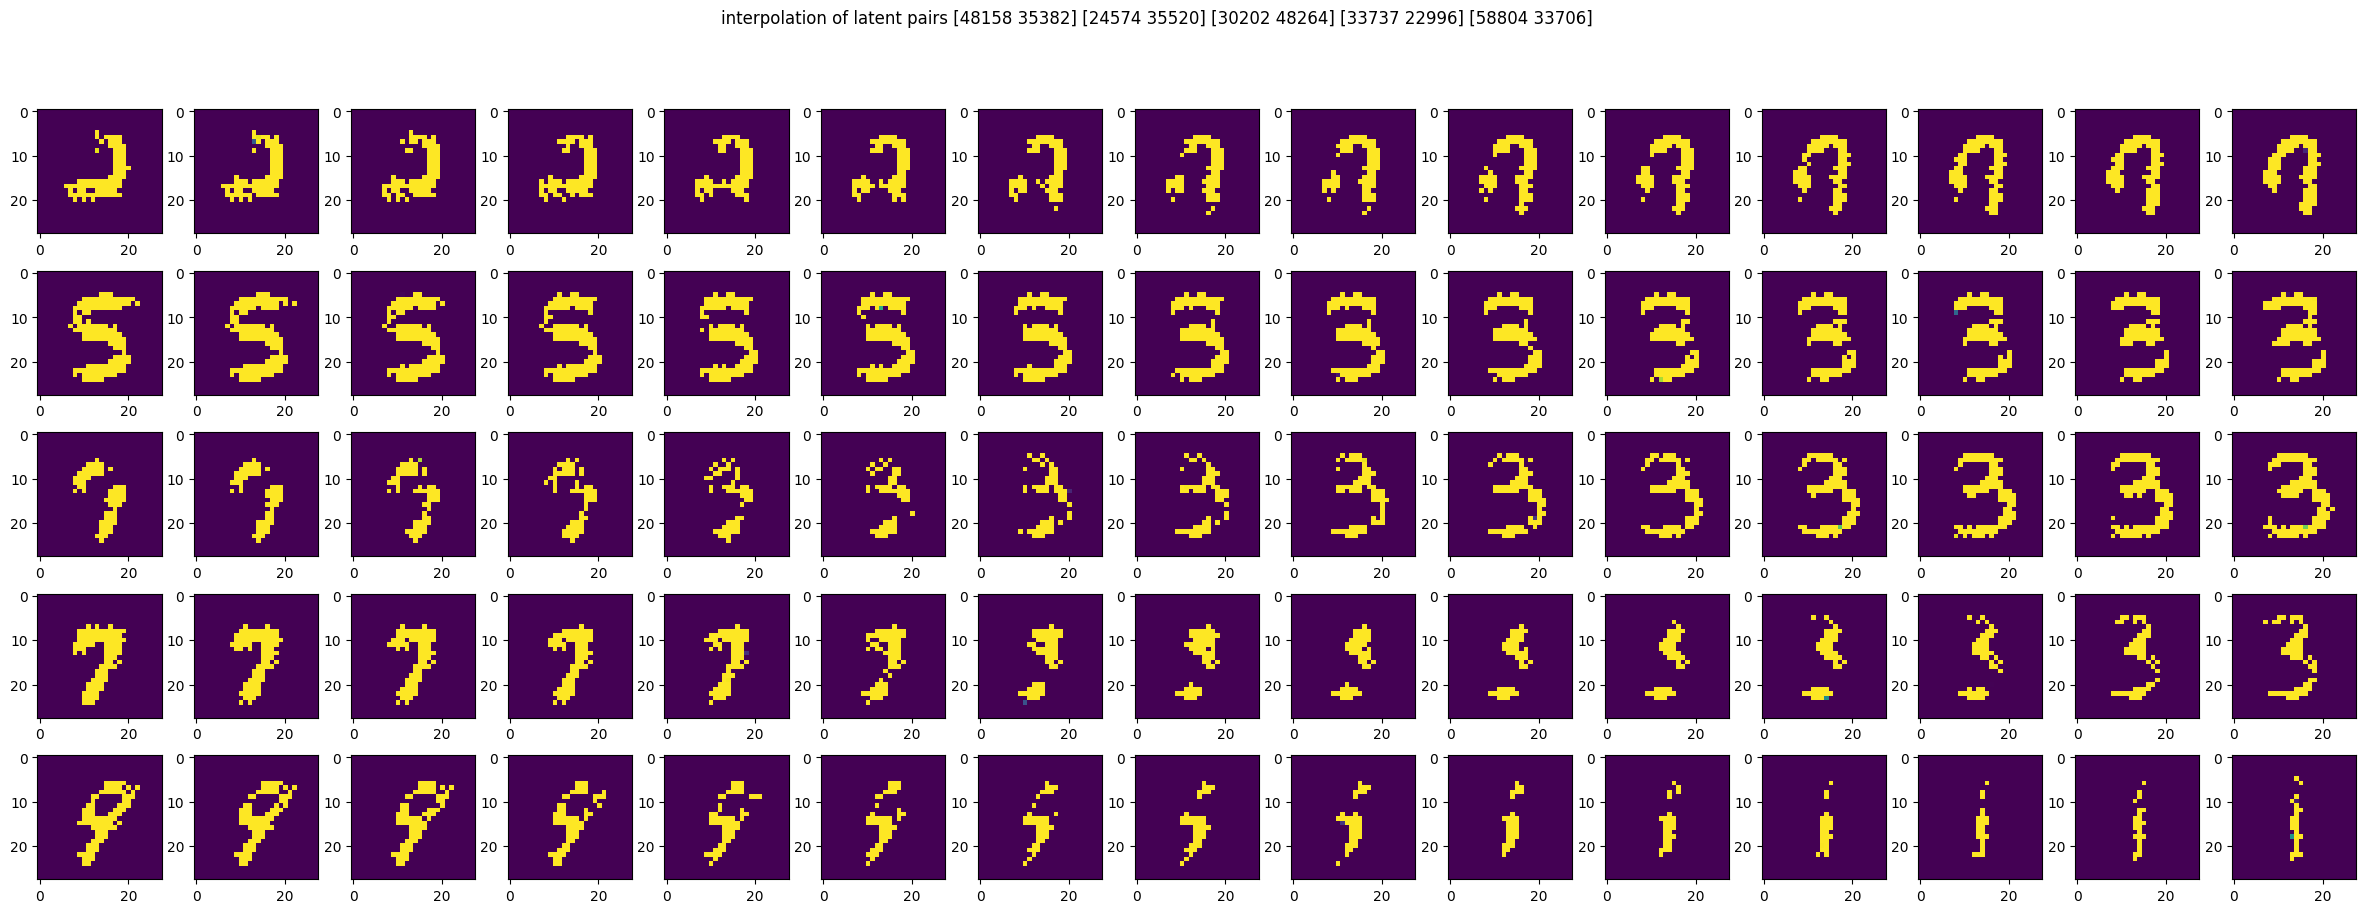

In [67]:
interpolate_and_plot(model_64,train_data)

# ***Q2) Variational Autoencoder (VAE): Train a VAE (on MNIST dataset) for the tasks of generating MNIST-like digits. Encoder learns a distribution in 16D space. After successfully training the VAE, generate 64 images and display.***

#KL-Divergence between statndard gasussian and P(Z|X) is:


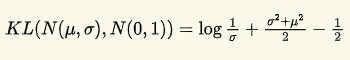

In [4]:
class Auto_VAE(nn.Module):
    def __init__(self, input_dim=784, latent_dim=16, hidden_dims=[256, 128, 64],loss='BCE'):
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.hidden_dims = hidden_dims
        #print("!!!!",self.input_dim,self.latent_dim,self.hidden_dims)
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_dims[0]),
            nn.ReLU(),
            nn.Linear(self.hidden_dims[0], self.hidden_dims[1]),
            nn.ReLU(),
            nn.Linear(self.hidden_dims[1], self.hidden_dims[2]),
            nn.ReLU(),
        )
        self.mean = nn.Linear(self.hidden_dims[2], self.latent_dim)
        self.logvar = nn.Linear(self.hidden_dims[2], self.latent_dim)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, self.hidden_dims[2]),
            nn.ReLU(),
            nn.Linear(self.hidden_dims[2], self.hidden_dims[1]),
            nn.ReLU(),
            nn.Linear(self.hidden_dims[1], self.hidden_dims[0]),
            nn.ReLU(),
            nn.Linear(self.hidden_dims[0], self.input_dim),
              
        )
        if loss=='BCE':
          self.out_non_linearity=nn.Sigmoid()  # Use sigmoid activation for BCELoss
        if loss=='MSE':
          self.out_non_linearity= nn.Tanh()

    def encode(self, x):
        #print(self.encoder)
        x = self.encoder(x)
        mean = self.mean(x)
        logvar = self.logvar(x)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def decode(self, z):
        x = self.decoder(z)
        x =  self.out_non_linearity(x)
        return x

    def forward(self, x):
        # Encode
        x = x.view(-1, 784)
        #print("Input X :",x.shape)
        mean, logvar = self.encode(x)
        #print("Encoder: z_mean ,z_log_var",mean.shape,logvar.shape)
        # Reparameterize
        z = self.reparameterize(mean, logvar)
        #print("reparametrize: z",z.shape)
        # Decode
        x_recon = self.decode(z)
        #print("x_hat: z",x_recon.shape)
        return x_recon, mean, logvar

def loss_function(x, x_recon, mean, logvar):
  # Reconstruction loss
  #print("@@@",x_recon.shape,x.shape)
  recon_loss = nn.BCELoss(reduction='sum')(x_recon, x)
  # KL divergence
  kl_div = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
  return recon_loss + 10*kl_div

def loss_function_mse(x, x_recon, mean, logvar):
  # Reconstruction loss
  #print("@@@",x_recon.shape,x.shape)
  recon_loss = nn.MSELoss(reduction='sum')(x_recon, x)
  # KL divergence
  kl_div = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
  return recon_loss + 0.8*kl_div


# Train VAE model
# Set hyperparameters
lr = 0.005
# hidden_dim = 16
# latent_dim = 8
epochs = 100
#batch_size = 128
#reg_lambda = 0.001


# Initialize VAE model and optimizer
model = Auto_VAE(loss='MSE')
optimizer = optim.Adam(model.parameters(), lr=lr)

train_loss_per_epoch=[]
for epoch in range(epochs):
    train_loss = 0.0
    for batch_idx, (data, _) in enumerate(train_loader):
        #print("***",data.shape)
        optimizer.zero_grad()
        x_hat, z_mean, z_log_var = model(data)
        #print("!!!",x_hat.shape,z_mean.shape,z_log_var.shape)
        #loss_MSE = vae_loss_mse(data.squeeze(1).reshape(128,-1), x_hat, z_mean, z_log_var)
        # loss_BCE = loss_function(data.squeeze(1).reshape(batch_size,-1), x_hat, z_mean, z_log_var)       
        # loss_BCE.backward()        
        #train_loss += loss_BCE.item()
        loss_MSE = loss_function_mse(data.squeeze(1).reshape(batch_size,-1), x_hat, z_mean, z_log_var)       
        loss_MSE.backward()        
        train_loss += loss_MSE.item()
        optimizer.step()
    train_loss_per_epoch.append(train_loss)
    print(f"***** Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss/len(train_loader.dataset):.4f} *******")





***** Epoch [1/100], Train Loss: 46.4658 *******
***** Epoch [2/100], Train Loss: 38.5430 *******
***** Epoch [3/100], Train Loss: 36.1724 *******
***** Epoch [4/100], Train Loss: 35.1370 *******
***** Epoch [5/100], Train Loss: 34.7312 *******
***** Epoch [6/100], Train Loss: 34.4433 *******
***** Epoch [7/100], Train Loss: 34.3782 *******
***** Epoch [8/100], Train Loss: 34.0888 *******
***** Epoch [9/100], Train Loss: 33.9990 *******
***** Epoch [10/100], Train Loss: 33.9165 *******
***** Epoch [11/100], Train Loss: 33.9524 *******
***** Epoch [12/100], Train Loss: 33.7843 *******
***** Epoch [13/100], Train Loss: 33.7457 *******
***** Epoch [14/100], Train Loss: 33.5993 *******
***** Epoch [15/100], Train Loss: 33.6875 *******
***** Epoch [16/100], Train Loss: 33.6743 *******
***** Epoch [17/100], Train Loss: 33.6196 *******
***** Epoch [18/100], Train Loss: 33.5528 *******
***** Epoch [19/100], Train Loss: 33.6020 *******
***** Epoch [20/100], Train Loss: 33.4341 *******
***** Epo

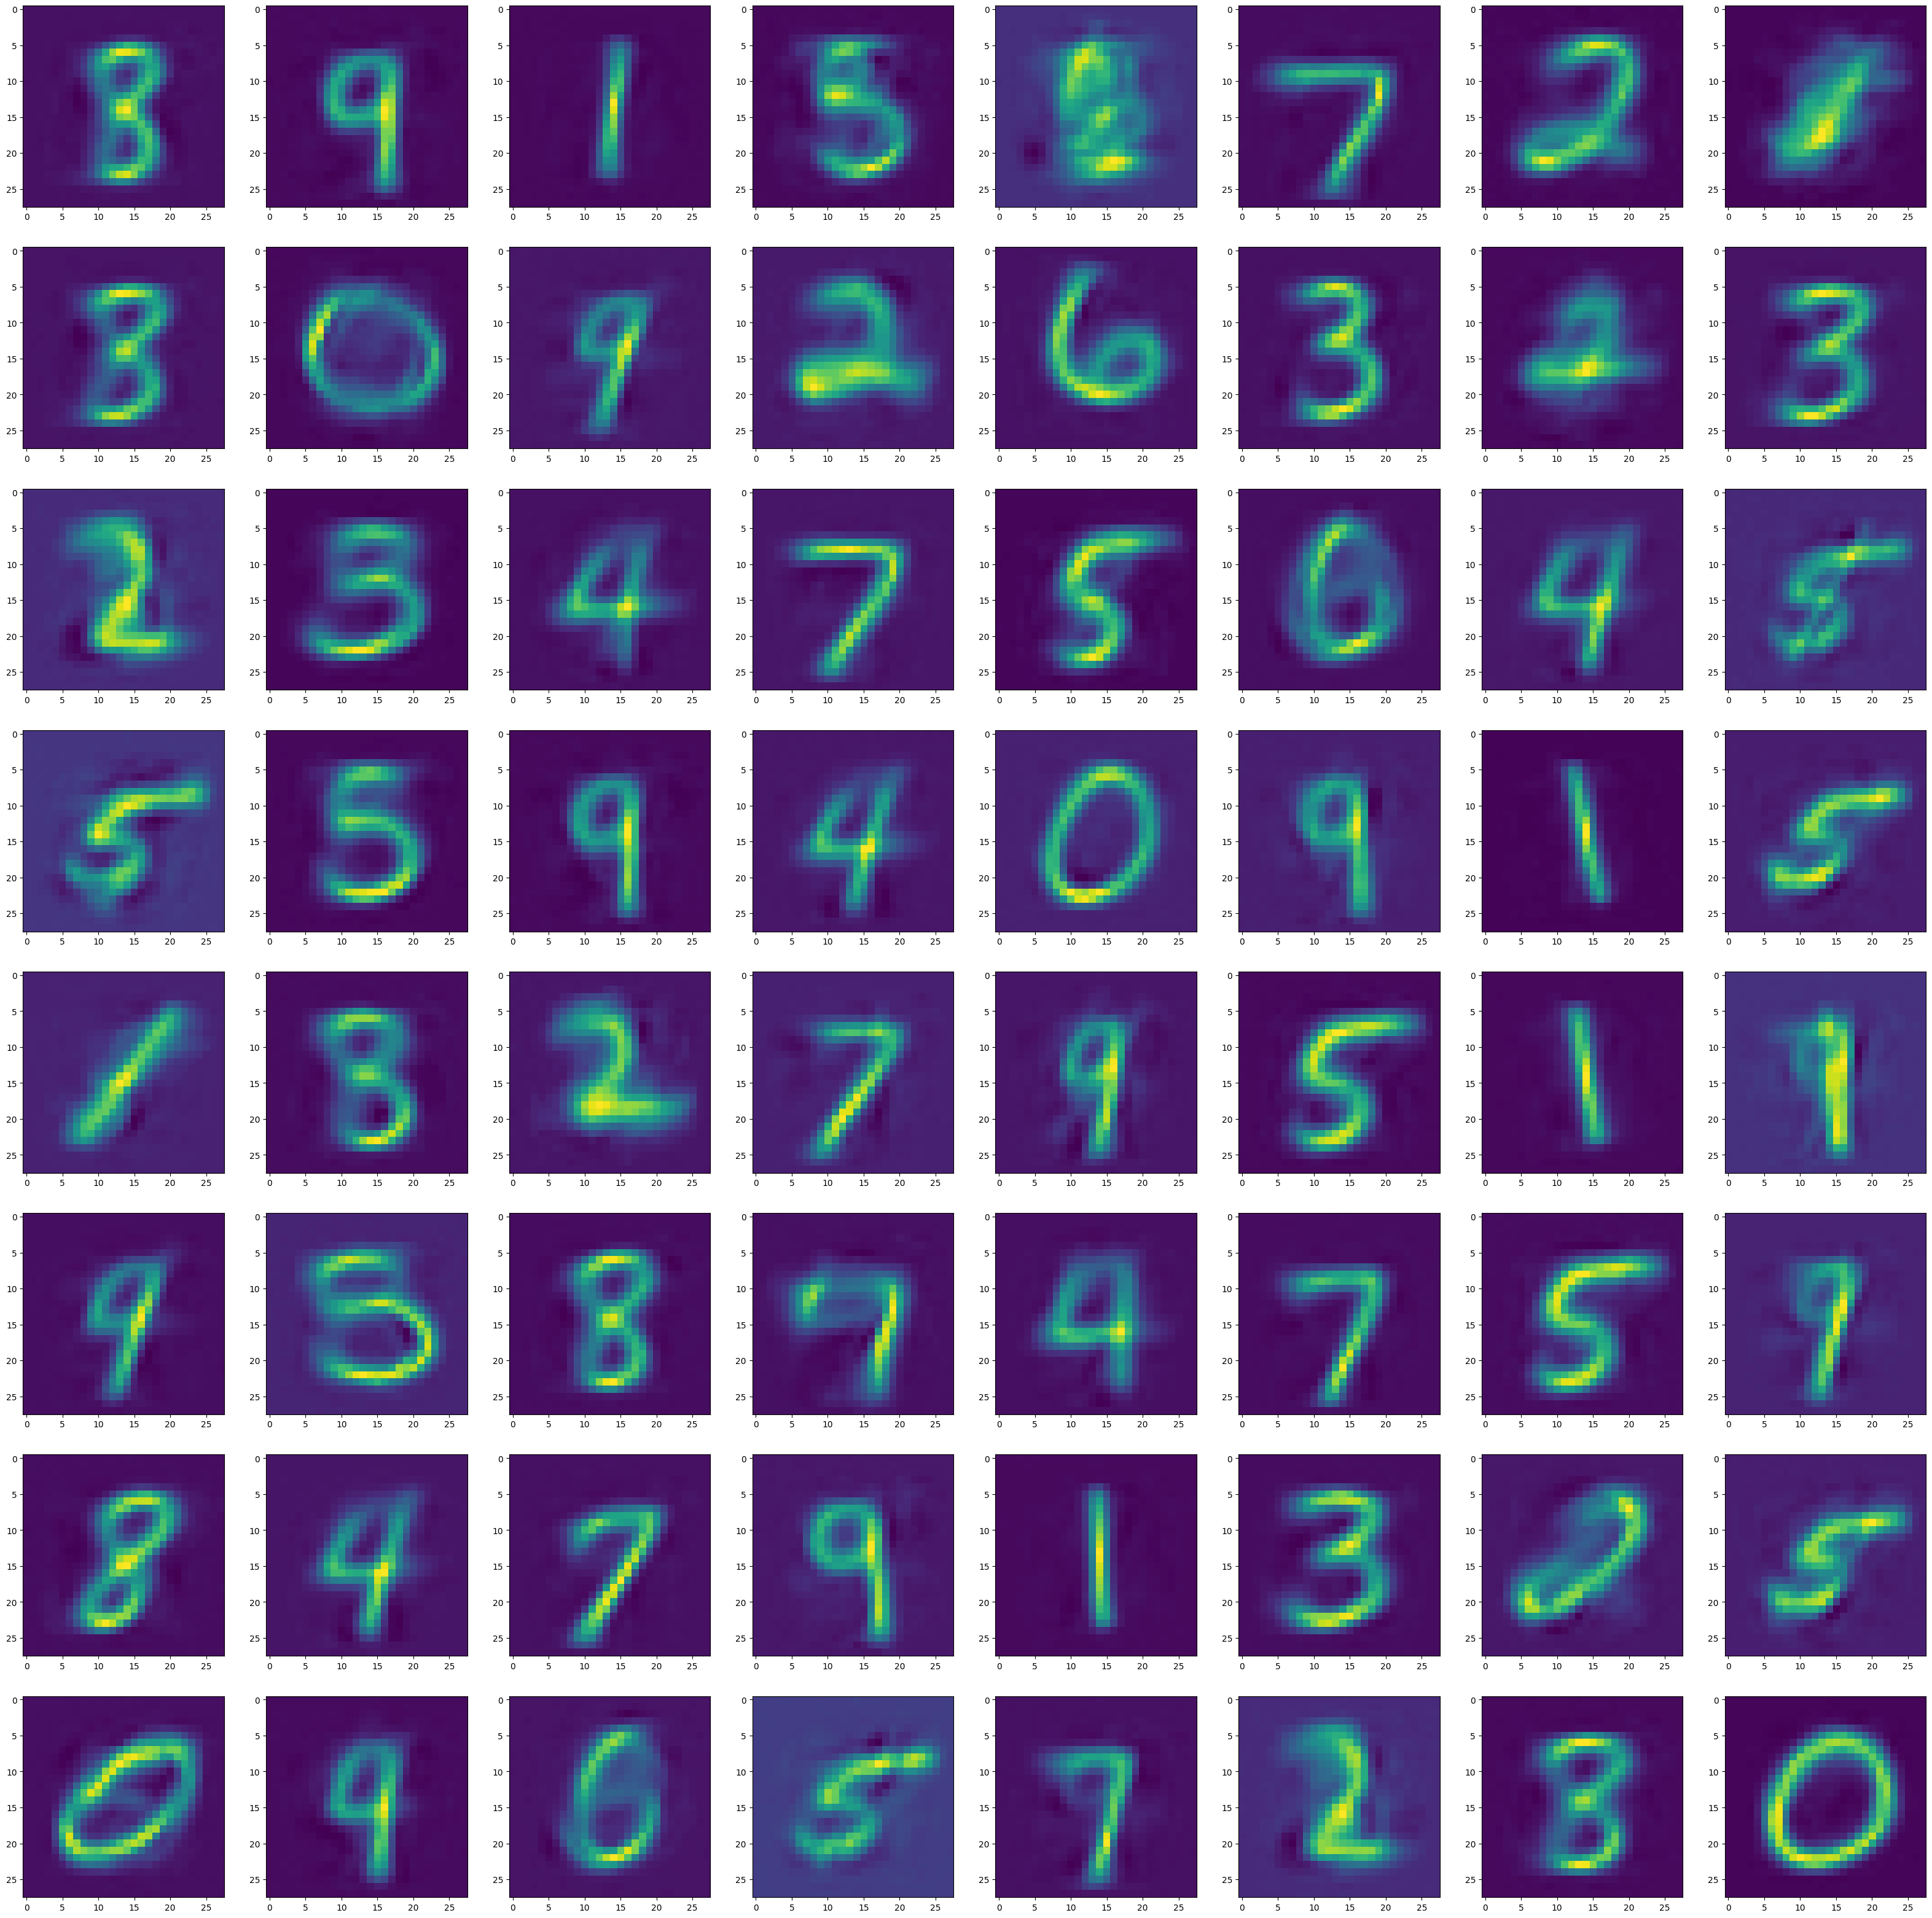

In [5]:
# Generate 64 images
gen_samples=[]
with torch.no_grad():
    for _ in range(64):
      z = torch.randn(16, 1)    
      sample = model.decoder(z.T)
      gen_samples.append(sample.reshape(28,28))
      #print("Generated Sample : ",sample.shape)
fig,ax=plt.subplots(nrows=8,ncols=8,figsize=(40,40))
for i in range(8):
  for j in range(8):
    ax[i][j].imshow(gen_samples[i*8+j].reshape(28,28))



# ***Q3) Self-Attention: Implement a CNN with one or more self-attention layer(s) for performing object recognition over CIFAR-10 dataset. The network can be a simpler one (with not more than 10 layers). You have to implement the self-attention layer. All other layers can be bulit-in implementations.***

In [70]:
trainset = CIFAR10(root='data', train=True,download=True, transform=ToTensor())
trainloader = torch.utils.data.DataLoader(trainset,shuffle=True)

testset = CIFAR10(root='data', train=False,download=True, transform=ToTensor())
testloader = torch.utils.data.DataLoader(testset, shuffle=True)

100%|██████████| 170498071/170498071 [00:14<00:00, 11676139.72it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


******while applying self attention in CNN 1) Encode input by passing it to a Conv layer which contains conv+Batchnorm+pool+relu and then conv+Batchnorm + SELF ATTENTION 
2)Self Attention will not take input from relu unit, it gives error
3)Motivation of this kind of a CNN with self atention comes papers like "Exploring Transformers in Emotion Recognition: a comparison of
BERT, DistillBERT, RoBERTa, XLNet and ELECTR", "NISQA: A Deep CNN-Self-Attention Model for Multidimensional Speech Quality Prediction with Crowdsourced Datasets" etc.****   **

In [78]:
import torch.nn.functional as F
class AttentionCNN(nn.Module):
    def __init__(self, num_attention_layers=1):

        super(AttentionCNN, self).__init__()

        self.convolute1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.convolute2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(16)
        self.attention_layers1 = SelfAttentionLayer(16, 16, 3) 

        self.convolute3 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(8)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.convolute4 = nn.Conv2d(8, 8, kernel_size=3, padding=1)
        self.batchnorm4 = nn.BatchNorm2d(8)
        self.attention_layers2 =SelfAttentionLayer(8, 8, 3)


        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.batchnorm1(self.convolute1(x))))        
        x = self.batchnorm2(self.convolute2(x))
        x=self.attention_layers1(x)
        x = self.pool2(F.relu(self.batchnorm3(self.convolute3(x))))        
        x = self.batchnorm4(self.convolute4(x))
        x=self.attention_layers2(x)
        #print("////",x.shape)
        x = x.view(-1, 8 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
class SelfAttentionLayer(nn.Module):
  
    def __init__(self, in_channels, out_channels, k_size):
        super(SelfAttentionLayer, self).__init__()
        self.query = nn.Conv2d(in_channels, out_channels, kernel_size=k_size, padding=k_size//2)
        self.key = nn.Conv2d(in_channels, out_channels, kernel_size=k_size, padding=k_size//2)
        self.value = nn.Conv2d(in_channels, in_channels, kernel_size=k_size, padding=k_size//2)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        batch_size, c, h, w = x.size()

        q = self.query(x).view(batch_size, -1, h*w)
        k = self.key(x).view(batch_size, -1, h*w)
        v = self.value(x).view(batch_size, c, -1)

        attn_matrix = torch.bmm(q.permute(0, 2, 1), k)
        attn_matrix = self.softmax(attn_matrix)

        attn_x = torch.bmm(v, attn_matrix)
        attn_x = attn_x.view(batch_size, c, h, w)

        return attn_x
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = AttentionCNN(num_attention_layers=1)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


In [79]:
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        #inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss / (i+1)}")

Epoch 1, Loss: 2.338014411488381
Epoch 2, Loss: 2.310086516554356
